In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [10]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(engine, reflect=True)

In [11]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [14]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

#View columns in 'station'
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
#View columns in 'measurement'
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [63]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
recent_date = dt.date(2017,8,23)
year_ago = (recent_date - dt.timedelta(days=365))

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > (recent_date - dt.timedelta(days=365))).all()
conn = engine.connect()
# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
precip_df.sort_values(by=['date'])
precip_df.dropna(subset=['precipitation'])

# Created a grouped dataframe by date to add the total precipitation per day.
total_precip_df = precip_df.groupby(['date']).sum()
total_precip_df.head()

,precipitation
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


Text(0, 0.5, 'inches')

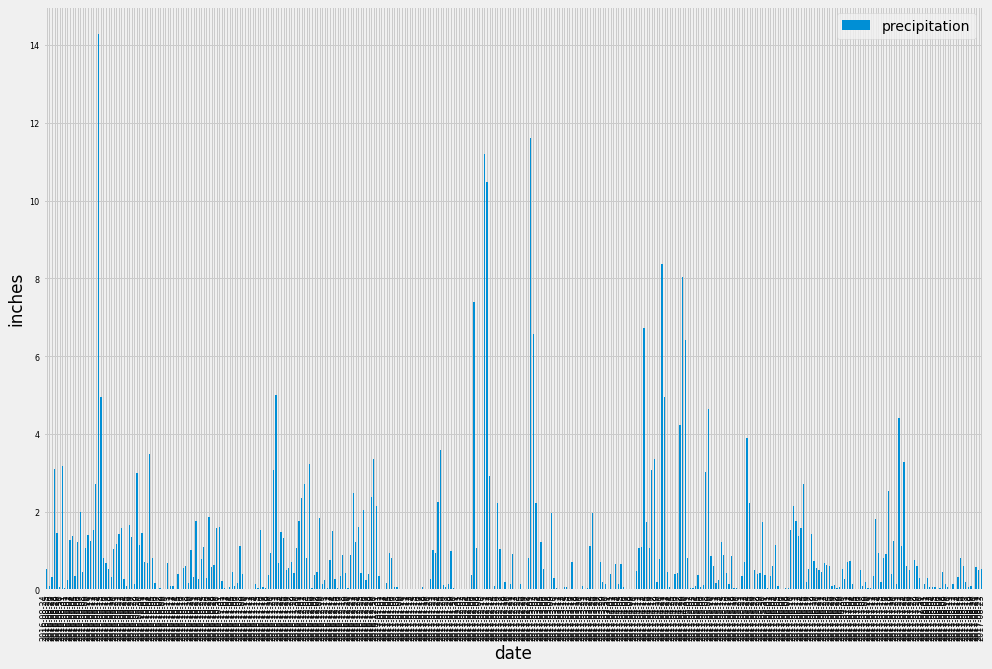

In [76]:
# Use Pandas Plotting with Matplotlib to plot the data

total_precip_df.plot.bar(rot=90,fontsize=8,figsize=(15,10))
plt.xlabel('date')
plt.ylabel('inches')



In [59]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [84]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).distinct(Measurement.station).count()

9

In [93]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
mostactive_station = session.query(Measurement.station,func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
session.query(Measurement.station,func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [99]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostactive_station[0]
session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == mostactive_station[0]).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

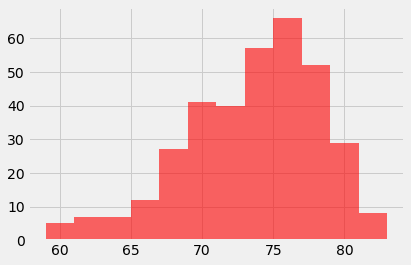

In [105]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == mostactive_station[0]).filter(Measurement.date > (recent_date - dt.timedelta(days=365))).all()
results
temp_df = pd.DataFrame(results, columns=['station', 'date','temp']).set_index('station')
x = temp_df['temp']
num_bins = 12
plt.hist(x,num_bins, facecolor='red', alpha=0.6)
plt.show()


# Close session

In [106]:
# Close Session
session.close()